# Obtaining Candidate Routes

## Using K-NN with Dijsktra's algorithm to get our testing set

This process is often one of the more computationally expensive parts of the process when it comes to map-matching. Caution must be used when designing such a method. Here we demonstrate how to use a K-nearest neighbors approach with Dijkstra's algorithm to get ourselves a candidate list of routes.

In [1]:
import networkx as nx
import osmnx as ox
import time
from shapely.geometry import Polygon, Point
import os, io, sys
import numpy as np
import ujson as json
import csv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from algorithms import mm_utils
import fiona

# Remove this when debugging
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
ox.__version__

#if not os.path.exists("temp/"):
#    os.makedirs("temp/")


ERROR 1: /usr/lib/gdalplugins/ogr_Arrow.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
ERROR 1: /usr/lib/gdalplugins/ogr_Arrow.so: undefined symbol: _ZNK5arrow8DataType18ComputeFingerprintB5cxx11Ev
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: /usr/lib/gdalplugins/ogr_Parquet.so: undefined symbol: _ZN5arrow2fs10FileSystem13NormalizePathENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
ERROR 1: /usr/lib/gdalplugins/ogr_Parquet.so: undefined symbol: _ZN5arrow2fs10FileSystem13NormalizePathENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE


'1.3.0'

<Axes: >

<Axes: >

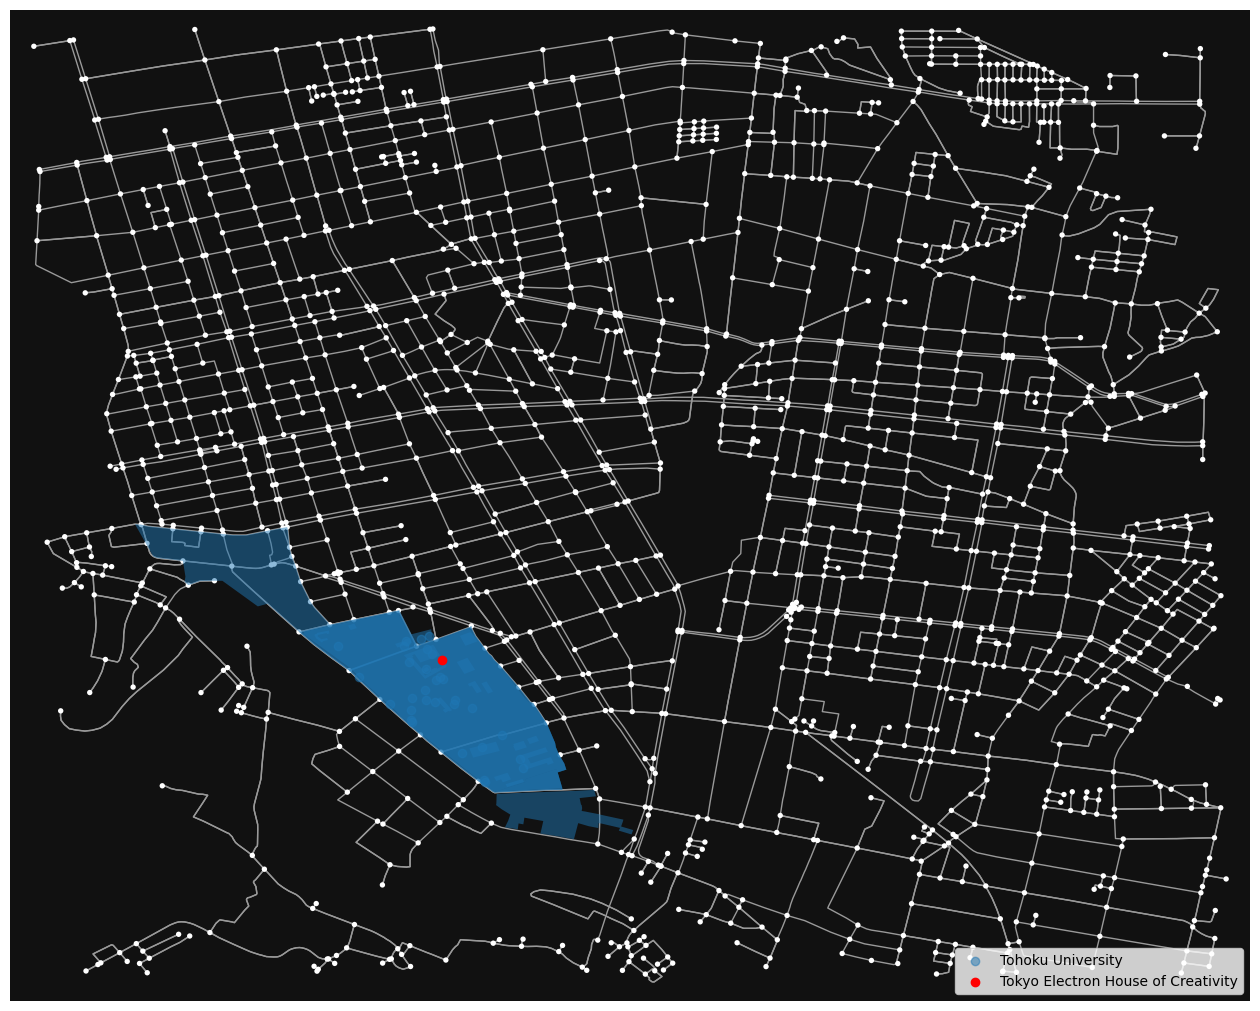

In [2]:
bignetwork = ox.graph_from_address(
"Sendai, Minamimachi-dori, Chuo 3-chome, Aoba Ward, Sendai, Miyagi Prefecture, 980-0021, Japan",
dist=1750, network_type='drive')

fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False,close=False)

campus = ox.geometries.geometries_from_place('Katahira Campus ',tags = {'name':True})
campus.plot(ax=ax, alpha=0.5)

gpd.GeoSeries([Point((140.87387,38.25448))]).plot(ax=ax, color='red')

ax.legend(handles=[ax.collections[4],ax.collections[5]],
          labels=['Tohoku University', 'Tokyo Electron House of Creativity'],
          loc = 'lower right')

The default format that OSMnx models networks is as `MultiDiGraph` objects. In order to manipulate these objects geometrically, we will need to convert this to `GeoDataFrame`. 

In [3]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(bignetwork)
#gdf_edges.dtypes
gdf_edges = gdf_edges.reset_index([0,1,2])
gdf_edges = gdf_edges.set_index('osmid')


In [10]:
gdf_edges.iloc[0].geometry.coords[1]

(140.8714835, 38.2660831)

Now let's look at the GPS data from a day walking around Sendai.

In [4]:
## We have some preprocessing to do first.

# Read the gpx directly
tripdata_nodes = gpd.read_file('Data/7-15-2022.gpx', layer = 'track_points')
    
# Read the IMU data directly
with open('Data/imu7-15-22 2_16_02.csv', mode = 'r') as f:
    tripdata_imu = csv.reader(f)
    tripdata_imu = pd.DataFrame(tripdata_imu)

# First we clean up the tripdata
tripdata_nodes = tripdata_nodes.dropna(axis=1, how = 'all')

# Let's convert the time into UNIX timestamps

from datetime import datetime as dt
import time

tripdata_nodes['time'] = (pd.to_datetime(tripdata_nodes['time']) - pd.Timestamp("1970-01-01").tz_localize("UTC")) // pd.Timedelta("1s")
tripdata_nodes = tripdata_nodes.rename(columns = {'time':'timestamp'})
tripdata_nodes = tripdata_nodes[['ele', 'timestamp', 'sat', 'geometry']]

# We will need the edges for FMM, so I wrote a helper function to create edges from points
tripdata_edges = mm_utils.point_to_traj(tripdata_nodes, columns = {'ele': 'average',
                                                                  'timestamp':'first',
                                                                  'sat':'first'})

# Now lets work on the IMU data.

tripdata_imu[0] = tripdata_imu[0].astype(float)

accel = []
for i in range(len(tripdata_imu)):
    row = tripdata_imu[[2,3,4]].loc[0]
    accel.append((float(tripdata_imu[[2,3,4]].loc[i].iloc[0]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[1]),
                  float(tripdata_imu[[2,3,4]].loc[i].iloc[2])))

    
#tripdata_imu = tripdata_imu.rename(columns = {'0':'timestamp', '})

# We need to convert the times to UNIX timestamps.
    
timediff = dt.strptime('2022-07-15T02:16:02', '%Y-%m-%dT%H:%M:%S').timestamp() - float(tripdata_imu[0][0])

# Not going to overwrite tripdata_imu yet because we haven't done gyro yet
newdf = pd.DataFrame({'timestamp': tripdata_imu[0] + timediff, 'accelerometer' : accel,})

# We will separate the gyroscope data for later because it isn't synchronous with the rest of the data
# We will simply fuse this at the end

gyro = []
gyrotime = []

for i in range(len(tripdata_imu)):
    if tripdata_imu[5].loc[i] is not None:
        if float(tripdata_imu[5].loc[i]) == 4:
            gyrotime.append(float(newdf['timestamp'].loc[i]))
            gyro.append((float(tripdata_imu[[6,7,8]].loc[i].iloc[0]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[1]),
                      float(tripdata_imu[[6,7,8]].loc[i].iloc[2])))

tripdata_gyro = pd.DataFrame({'timestamp':gyrotime, 'gyroscope':gyro})

tripdata_imu = newdf


Now let's fuse!

In [5]:
tripdata_nodes = mm_utils.fuse(mm_utils.fuse(tripdata_nodes, tripdata_imu, 'timestamp', 'nearest neighbor'), tripdata_gyro, 'timestamp', 'nearest neighbor')

<Axes: >

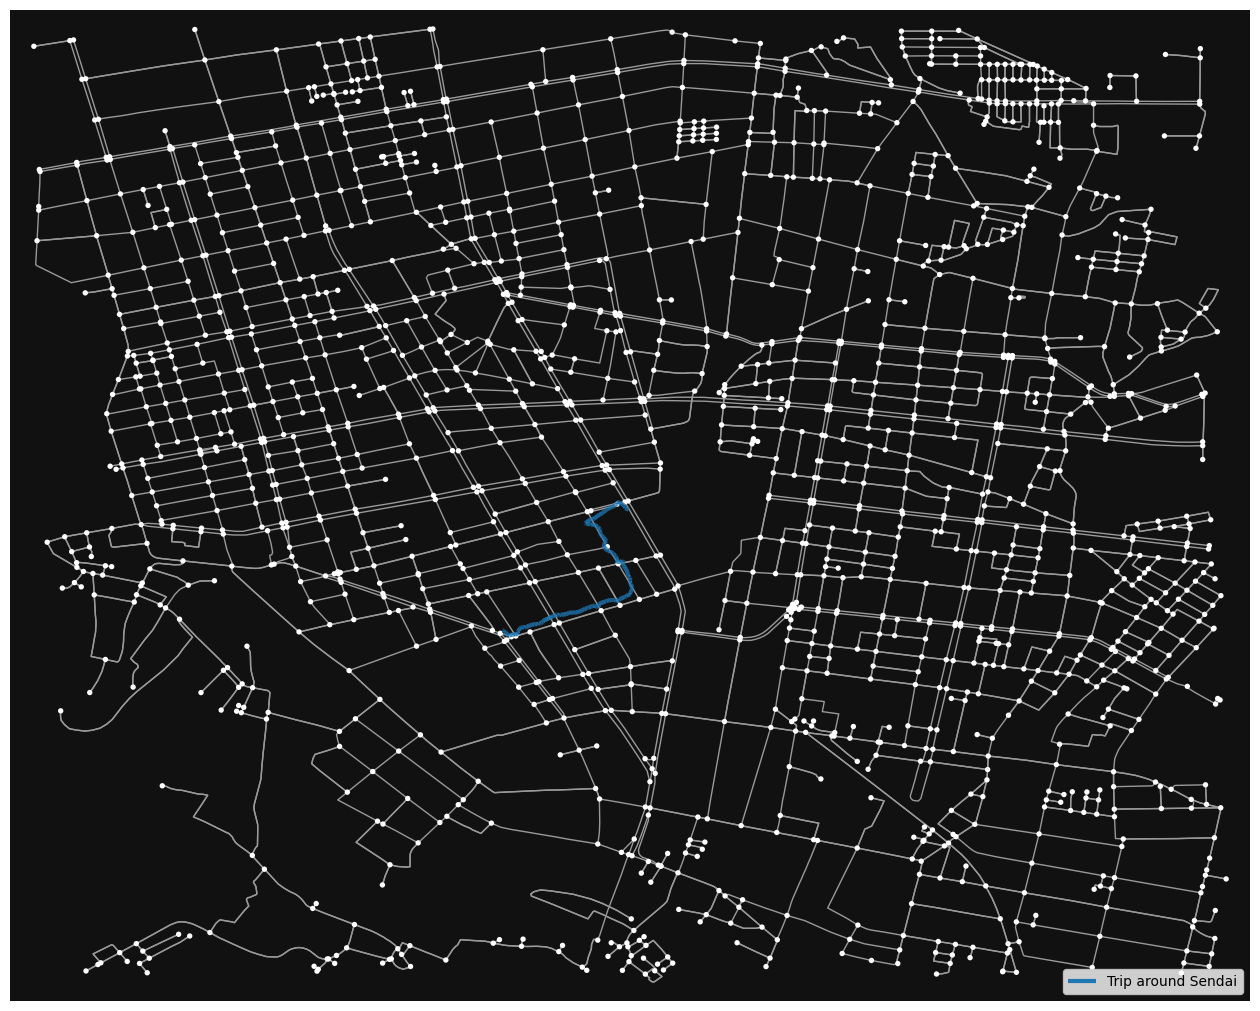

In [6]:
fig, ax = ox.plot_graph(bignetwork, figsize = (16,16),show=False, close=False)
#tripdata_nodes.plot(ax=ax)
tripdata_edges.plot(ax=ax, linewidth=3)
ax.legend(handles=[ax.collections[2]],labels=['Trip around Sendai'], loc = 'lower right')

Let's zoom in a bit.

Let's get candidate edges

In [7]:
candidates = mm_utils.get_nearest_edges(tripdata_nodes, gdf_edges, k_neighbors = 8, r = 0.001)

<Axes: >

<Axes: >

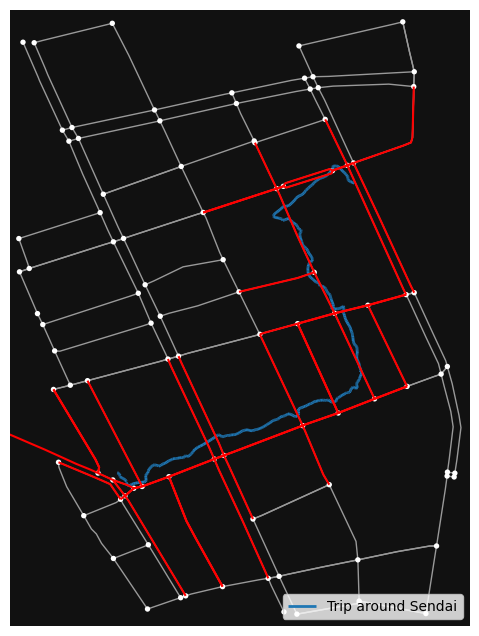

In [8]:
from functools import reduce

all_candidate_edges = reduce(lambda left,right: pd.concat([left, right]).drop_duplicates(subset=['geometry'])
, candidates)

smallnetwork = mm_utils.df_to_network(tripdata_nodes, as_gdf = False)
fig, ax = ox.plot_graph(smallnetwork, figsize=(8,8), show=False, close=False)
tripdata_edges.plot(ax=ax, linewidth=2)
all_candidate_edges.plot(ax=ax, color='red')
ax.legend(handles=[ax.collections[2]],labels=['Trip around Sendai'], loc = 'lower right')



Note that at the moment we only have a collection of possible edges; these are not yet formed into candidate routes.

In [9]:
qry_pts =  [(x,y) for x,y in zip(gdf_nodes.geometry.x , gdf_nodes.geometry.y)]

source_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[0].x, tripdata_nodes['geometry'].iloc[0].y)], qry_pts, k_neighbors = 1)
source_index = source_index[0][0]

target_index, _ = mm_utils.get_nearest([(tripdata_nodes['geometry'].iloc[-1].x, tripdata_nodes['geometry'].iloc[-1].y)], qry_pts, k_neighbors = 1)
target_index = target_index[0][0]

We use a variant on Dijkstra's method to find candidate routes. The main difference in the algorithm from the standard implementation is that we keep 'bad' routes, and we want n shortest routes, not just the shortest. We also don't need to enumerate all of the routes; it is reasonably likely that we will find the shortest within the first n candidates found, so we can just stop once we have gathered our n routes.

The algorithm stops if it has enumerated all possible routes before hitting n, and simply returns every route it found. Unfortunately, there is no way a priori to determine how many candidate routes can be constructed; so if you need to have a set number of candidates, you may need to run a loop which increases the radius/k-NN for finding candidate edges, and re-runs Dijkstra's on the new list.

This is of course inefficient, but in practice not usually an issue. If you are running out of candidate routes before hitting your desired number, the algorithm will find those candidate routes rather quickly, and so it is not actually a serious concern.

In [10]:
candidate_routes, _ = mm_utils.dijkstra(gdf_nodes.iloc[source_index].geometry, gdf_nodes.iloc[target_index].geometry, all_candidate_edges, n=100, one_way = False)

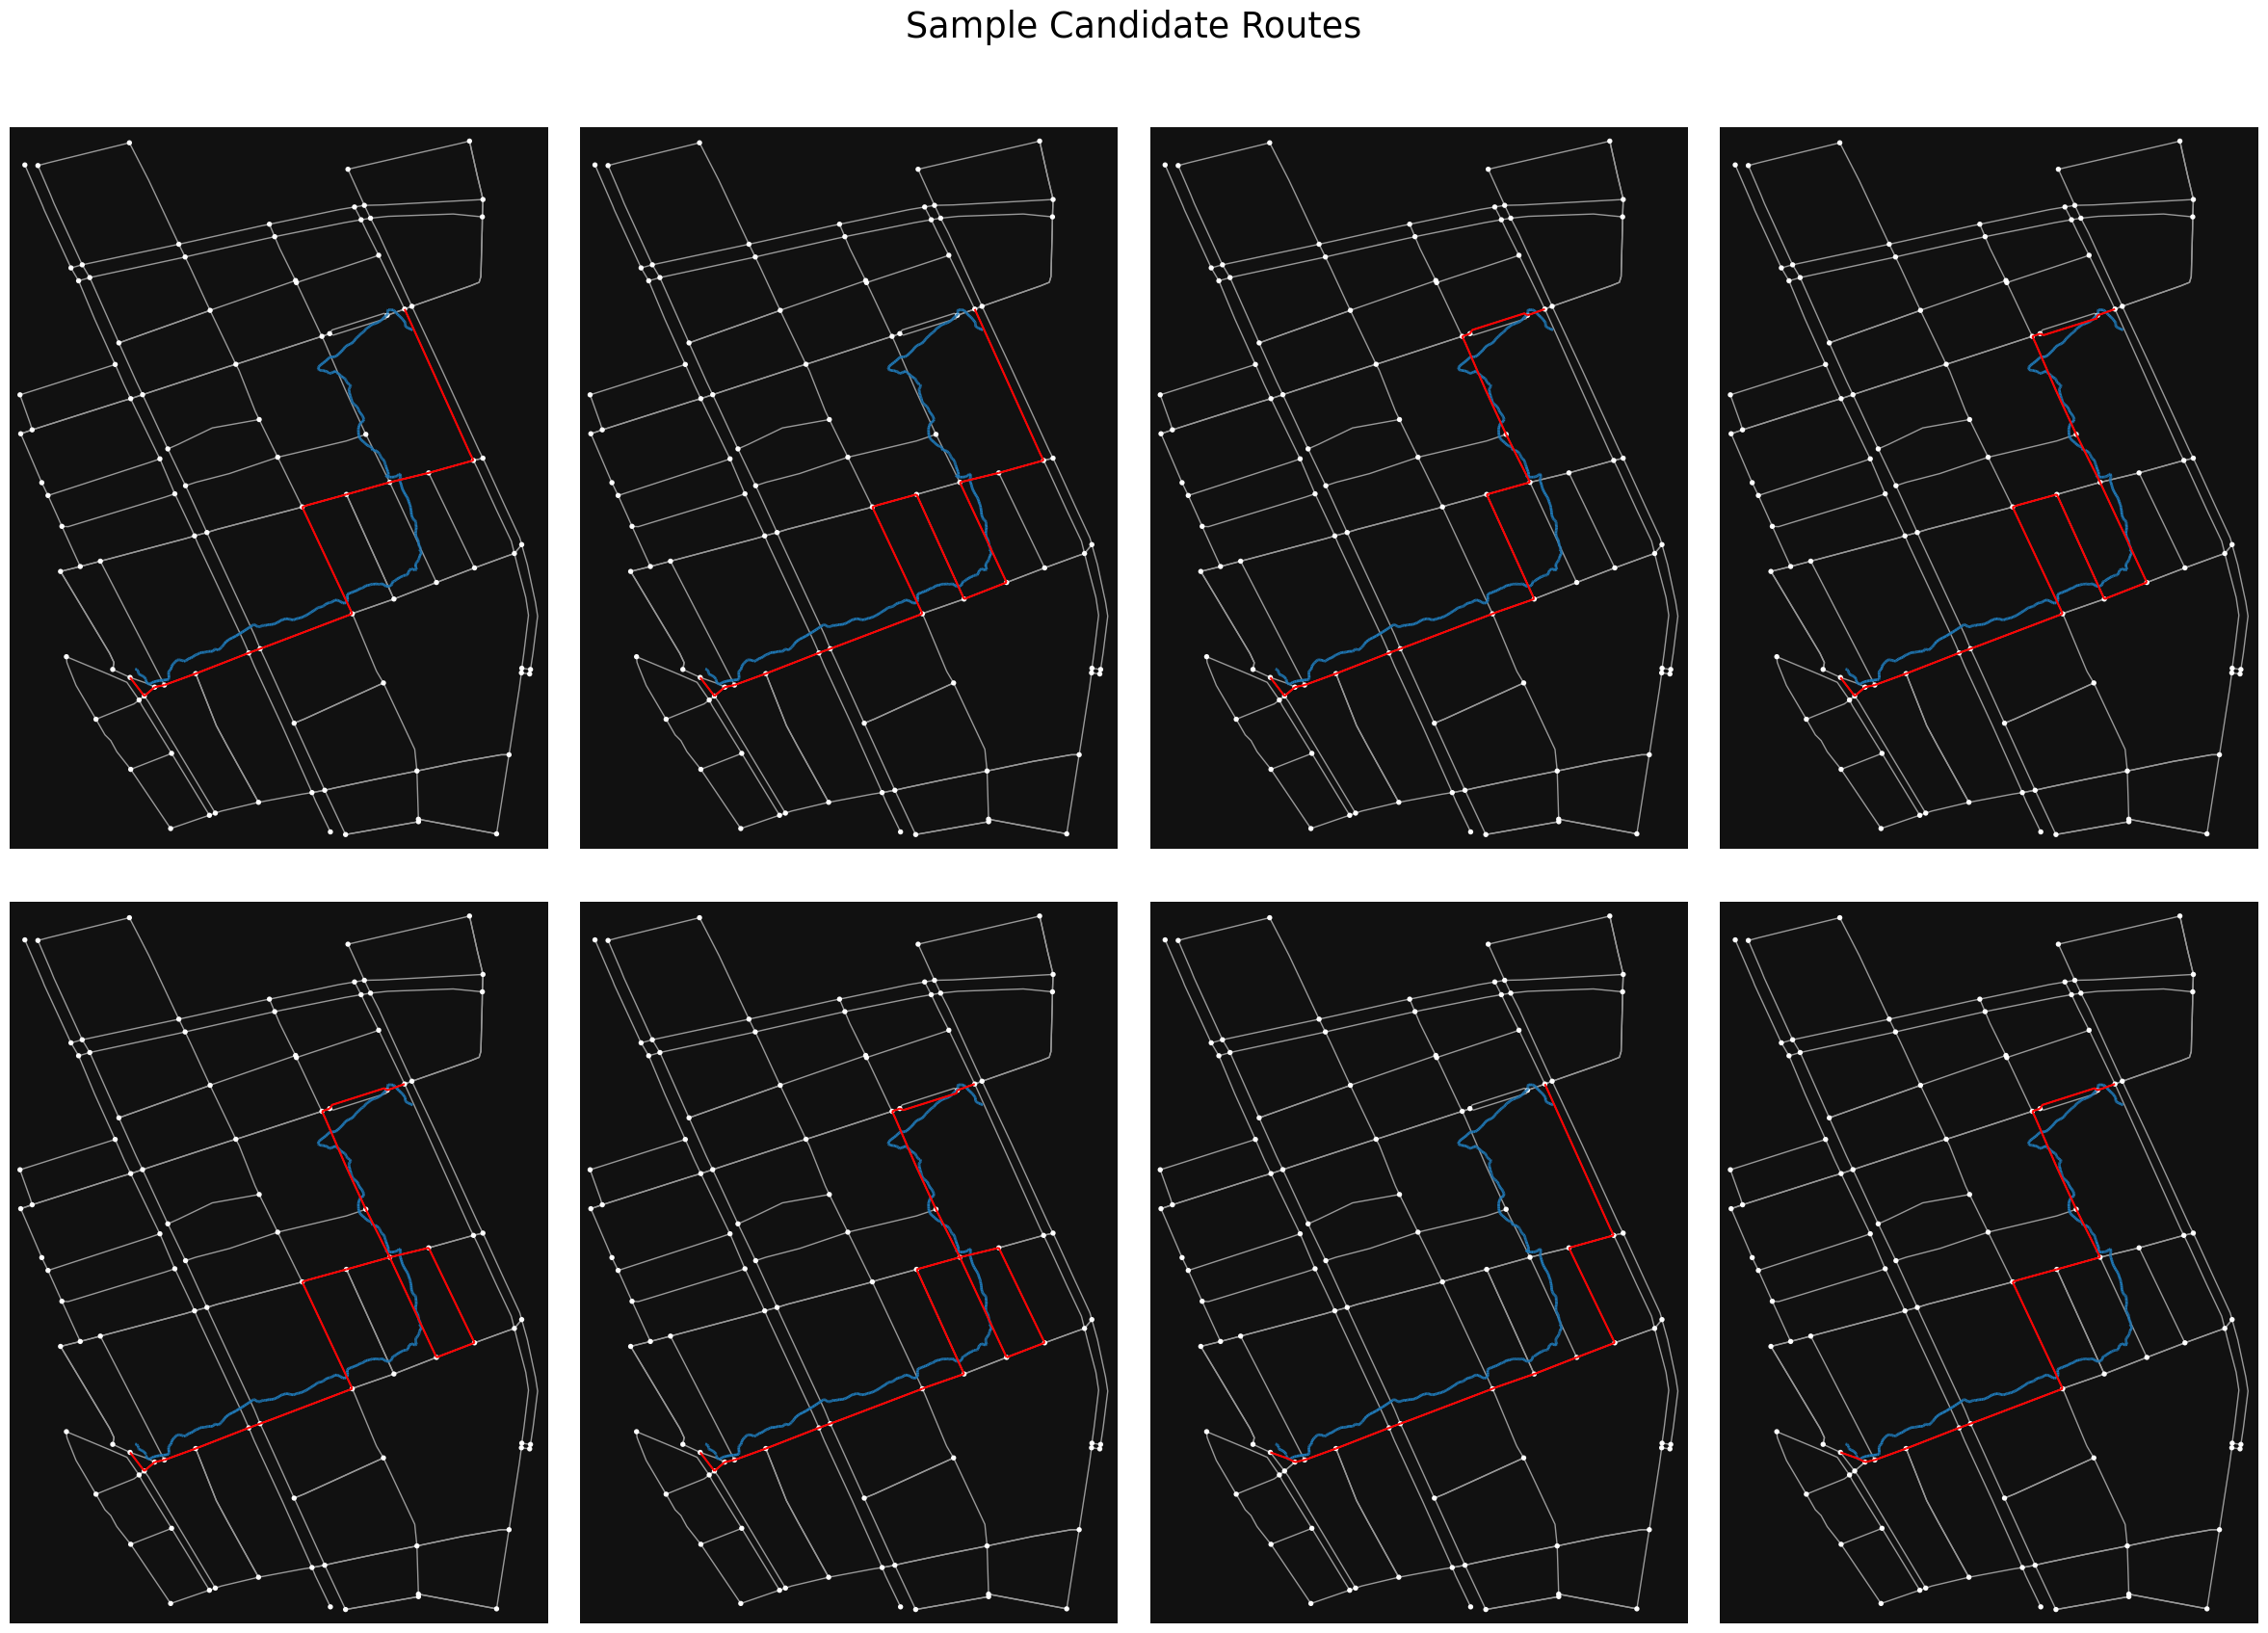

In [64]:
a=2
b=4

fig, axs = plt.subplots(a,b,figsize=(b*6,a*9))



for i in range(a*b):
    ox.plot_graph(smallnetwork, ax=axs[int(np.floor(i/b)),int(i%b)], show=False, close=False)
    axs[int(np.floor(i/b)),int(i%b)].set_facecolor('#111111')
    tripdata_edges.plot(ax=axs[int(np.floor(i/b)),int(i%b)], linewidth=2, aspect=None)
    candidate_routes[5*i].plot(ax=axs[int(np.floor(i/b)),int(i%b)], color='red', aspect=None)

matplotlib.rcParams.update({'font.size': 22})

fig.suptitle('Sample Candidate Routes')

plt.tight_layout()

plt.show();

#ax.legend(handles=[ax.collections[2]],labels=['Trip around Sendai'], loc = 'lower right')
